# Задание 1


Выберите 5 языков в википедии (не тех, что использовались в семинаре). Скачайте по 10 случайных статей для каждого языка. Предобработайте тексты, удаляя лишние теги/отступы/разделители (если они есть). Разделите тексты на предложения и создайте датасет, в котором каждому предложению соответствует язык. Кластеризуйте тексты, используя эбмединг модель из прошлого семинара и любой алгоритм кластеризации. Проверьте качество кластеризации с помощь метрики ARI.

In [3]:
import wikipedia
import numpy as np
import os
import json
import requests

In [4]:
code2lang = wikipedia.languages()

In [5]:
langs = ['pl', 'ab', 'ady', 'ace' , 'it']

In [6]:
[(lang, code2lang[lang]) for lang  in langs]

[('pl', 'polski'),
 ('ab', 'аԥсшәа'),
 ('ady', 'адыгабзэ'),
 ('ace', 'Acèh'),
 ('it', 'italiano')]

In [7]:
def load_with_disambigution(page):
    try:
        p = wikipedia.page(page)
    except wikipedia.DisambiguationError as e:
        random_option = np.random.choice(e.options)
        p = wikipedia.page(random_option)
    return p


In [8]:
def get_texts_for_lang(lang, n=100): # функция для скачивания статей из википедии
    # вот так можно зафиксировать язык
    wikipedia.set_lang(lang)
    wiki_content = []
    
    # random достает только ссылки на статьи
    pages = wikipedia.random(n)
    
    for page_name in pages:
        try:
            # чтобы загрузить контент статьи можно вызвать функцию .page
            page = load_with_disambigution(page_name)
        
        except Exception as e:
            print('Skipping page {}'.format(page_name), e)
            continue

        wiki_content.append(f'{page.title}\n{page.content.replace("==", "")}')

    return wiki_content

In [ ]:
wiki_texts = {}

for lang in langs:
    try:
        wiki_texts[lang] = get_texts_for_lang(lang, 10)
    except Exception as e:
        print('ERROR ON - ', lang, e)
        continue
    
    print(lang, len(wiki_texts[lang]))

In [ ]:
wiki_texts

In [11]:
import re

In [12]:
cleaned_articles = []
for language in wiki_texts:
    for article in wiki_texts[language]:
        article = re.sub(r'\s+', ' ', article)
        article = re.sub('<[^>]+>', '', article)
        cleaned_articles.append(article)

In [ ]:
for article in cleaned_articles:
    print(article)

In [ ]:
cleaned_articles

In [13]:
from nltk import sent_tokenize

In [17]:
langs = ['pl', 'pl', 'pl', 'pl', 'pl', 'pl', 'pl', 'pl', 'pl', 'pl', 'ab', 'ab', 'ab', 'ab', 'ab', 'ab', 'ab', 'ab', 'ab', 'ab', 'ady', 'ady', 'ady', 'ady', 'ady', 'ady', 'ady', 'ady', 'ady', 'ady', 'ace' , 'ace', 'ace' , 'ace', 'ace', 'ace' , 'ace', 'ace' , 'ace', 'ace', 'it', 'it', 'it', 'it', 'it', 'it', 'it', 'it', 'it', 'it']
sentences = {}
n = int(0)
for article in cleaned_articles:
    tokenized_article = sent_tokenize(article)
    for sentence in tokenized_article:
        sentences[sentence] = langs[n]
    n += 1

In [ ]:
sentences

-------------------------

In [19]:
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity
from sentence_transformers import SentenceTransformer
import pandas as pd
from sklearn.cluster import KMeans

In [20]:
# embedding model
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
embed = model.encode

In [21]:
from sklearn.cluster import KMeans, DBSCAN, AffinityPropagation
import numpy as np
from sklearn.metrics import adjusted_rand_score

from IPython.display import Image
from IPython.core.display import HTML
from sklearn.preprocessing import LabelEncoder

In [32]:
ARI = []
texts = []
for key in sentences:
    # вытаскиваем предложения
    texts.append(key)

In [38]:
true_lables = []
for key in sentences:
    # вытаскиваем языки
    true_lables.append(sentences.get(key))

In [ ]:
true_lables

In [ ]:
texts

In [42]:
    # создаем пустую матрицу для векторов 
X = np.zeros((len(texts), 768))

    # переводим тексты в векторы и кладем в матрицу
for i, text in enumerate(texts):
        X[i] = embed(text)

    # выбираем один из алгоритмов
#cluster = AffinityPropagation(damping=0.9)
cluster = KMeans(5)
#     cluster = DBSCAN(min_samples=1, eps=0.1)
    
cluster.fit(X)
labels = np.array(cluster.labels_)+1 

label_encoder = LabelEncoder()
label_encoder.fit(true_lables)
ARI.append(adjusted_rand_score(label_encoder.transform(true_lables), labels))
    
print(np.mean(ARI)) # усредненная метрика

0.8309391221489596


c:\Users\Dmitry\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


# Задание 2

Загрузите корпус `annot.opcorpora.no_ambig_strict.xml.bz2` с OpenCorpora. Найдите в корпусе самые частотные морфологически омонимичные словоформы (те, которым соответствует разный грамматический разбор). Также найдите словоформы с самых большим количеством вариантов грамматических разборов.

In [52]:
import requests

In [56]:
import bz2

with bz2.open('data/annot.opcorpora.no_ambig_strict.xml.bz2', 'rb') as f_in, open('data/annot.opcorpora.no_ambig_strict.xml', 'wb') as f_out:
    f_out.write(f_in.read())

In [61]:
from lxml import etree
from pymorphy2 import MorphAnalyzer
from sklearn.metrics import classification_report
import numpy as np
from collections import Counter

In [63]:
open_corpora = etree.fromstring(open('data/annot.opcorpora.no_ambig_strict.xml', 'rb').read())

In [64]:
sentences2 = open_corpora.xpath('//tokens')

In [67]:
tokens = sentences2[0].xpath('token')

In [68]:
[token.xpath('@text')[0] for token in tokens]

['«', 'Школа', 'злословия', '»', 'учит', 'прикусить', 'язык']

In [72]:
[token.xpath('tfr/v/l/g/@v')[0] for token in tokens]

['PNCT', 'NOUN', 'NOUN', 'PNCT', 'VERB', 'INFN', 'NOUN']

In [73]:
corpus = []

for sentence in open_corpora.xpath('//tokens'):
    sent_tagged = []
    for token in sentence.xpath('token'):
        word = token.xpath('@text')
        gram_info = token.xpath('tfr/v/l/g/@v')
        sent_tagged.append([word[0]] + gram_info)
    
    corpus.append(sent_tagged)

In [75]:
corpus[0]

[['«', 'PNCT'],
 ['Школа', 'NOUN', 'inan', 'femn', 'sing', 'nomn'],
 ['злословия', 'NOUN', 'inan', 'neut', 'sing', 'gent'],
 ['»', 'PNCT'],
 ['учит', 'VERB', 'impf', 'tran', 'sing', '3per', 'pres', 'indc'],
 ['прикусить', 'INFN', 'perf', 'tran'],
 ['язык', 'NOUN', 'inan', 'masc', 'sing', 'accs']]

In [92]:
# Создаем словарь, где ключ это словоформа, а значение это сет кортежей, представлющих разные значения

word_forms_freq = {}

for sentence in corpus:
    for word in sentence:
        if word[0] not in word_forms_freq:
            word_forms_freq[word[0]] = set()
            word_meanings = set()
            for word_meaning in word[1:]:               
                if word_meaning not in word_meanings:
                    word_meanings.add(word_meaning)
            word_forms_freq[word[0]].add(tuple(word_meanings))
        else:
            word_meanings2 = set()
            for word_meaning2 in word[1:]:               
                if word_meaning2 not in word_meanings2:
                    word_meanings2.add(word_meaning2)
            word_forms_freq[word[0]].add(tuple(word_meanings2))

In [ ]:
word_forms_freq

In [104]:
# Ищем  слово с максимальным количество омонимии
word_forms_max_meanings = {}
max_meanings_wordform = set()
max_meanings_digit = int(0)
for wordform in word_forms_freq:
    word_forms_max_meanings[wordform] = len(word_forms_freq[wordform])

for wordform in word_forms_max_meanings:
    if word_forms_max_meanings[wordform] > max_meanings_digit:
        max_meanings_digit = word_forms_max_meanings[wordform]

for wordform in word_forms_max_meanings:
    if word_forms_max_meanings[wordform] == max_meanings_digit:
        max_meanings_wordform.add(wordform)

# выводим это слово
max_meanings_wordform

{'США'}

In [119]:
# Ищем слова с 2 и более значениями
wordforms_omon = set()

for wordform in word_forms_freq:
    if len(word_forms_freq[wordform]) >= 2:
        wordforms_omon.add(wordform)

wordforms_omon = tuple(wordforms_omon)

In [ ]:
# Создаём словарь для подсчета количества вхождений
wordform_count = {word: 0 for word in wordforms_omon}

# Считаем количество вхождений слов
for sentence in corpus:
    for word in sentence:
        if word[0] in wordforms_omon:
            wordform_count[word[0]] += 1

wordform_count

In [128]:
sorted_wordforms_omon = sorted(wordform_count, key=wordform_count.get, reverse=True)[:20]

# Выводим 20 самых частотных омонимичных словоформ
for wordform in sorted_wordforms_omon:
    print(f"Словоформа: {wordform}, Кол-во вхождений: {wordform_count[wordform]}")


Словоформа: в, Кол-во вхождений: 1583
Словоформа: на, Кол-во вхождений: 686
Словоформа: с, Кол-во вхождений: 536
Словоформа: и, Кол-во вхождений: 507
Словоформа: году, Кол-во вхождений: 115
Словоформа: этом, Кол-во вхождений: 104
Словоформа: России, Кол-во вхождений: 90
Словоформа: было, Кол-во вхождений: 84
Словоформа: может, Кол-во вхождений: 65
Словоформа: А, Кол-во вхождений: 58
Словоформа: которые, Кол-во вхождений: 53
Словоформа: нет, Кол-во вхождений: 48
Словоформа: меня, Кол-во вхождений: 48
Словоформа: всех, Кол-во вхождений: 47
Словоформа: этого, Кол-во вхождений: 47
Словоформа: О, Кол-во вхождений: 45
Словоформа: человек, Кол-во вхождений: 45
Словоформа: США, Кол-во вхождений: 44
Словоформа: этой, Кол-во вхождений: 41
Словоформа: против, Кол-во вхождений: 41


## Задание 3
Загрузите один и з файлов корпуса Syntagrus - https://github.com/UniversalDependencies/UD_Russian-SynTagRus/tree/master (можно взять тестовый)

Преобразуйте все разборы предложений в графовые структуру через DependencyGraph, выберите отношение (из тех, что не упоминались на семинаре) и найдите самые частотные пары слов, связанных этим отношением. 

Для самой частотной пары вытащите все подзависимые слова для каждого из них во всех предложениях (используя `flatten(get_subtree(d.nodes, index_of_a_word)`) В итоге у вас должен получится список пары: слово1 и все его подзависимые - слово2 и все его подзависимые.

Визуализируйте самое длинное предложение через networkx

In [132]:
from nltk.grammar import DependencyGrammar
from nltk.parse import DependencyGraph
from collections import Counter
import numpy as np
import re
import warnings
import os
warnings.filterwarnings('ignore')

In [169]:
from collections import defaultdict

In [136]:
file = open('data/ru_syntagrus-ud-test.conllu', 'r', encoding='utf-8').read()

In [138]:
tree = [x for x in file.split('\n\n')[0].split('\n')]

In [139]:
tree

['# sent_id = 2003Armeniya.xml_1',
 '# text = В советский период времени число ИТ- специалистов в Армении составляло около десяти тысяч.',
 '1\tВ\tв\tADP\t_\t_\t3\tcase\t3:case\t_',
 '2\tсоветский\tсоветский\tADJ\t_\tAnimacy=Inan|Case=Acc|Degree=Pos|Gender=Masc|Number=Sing\t3\tamod\t3:amod\t_',
 '3\tпериод\tпериод\tNOUN\t_\tAnimacy=Inan|Case=Acc|Gender=Masc|Number=Sing\t11\tobl\t11:obl:в:acc\t_',
 '4\tвремени\tвремя\tNOUN\t_\tAnimacy=Inan|Case=Gen|Gender=Neut|Number=Sing\t3\tnmod\t3:nmod:gen\t_',
 '5\tчисло\tчисло\tNOUN\t_\tAnimacy=Inan|Case=Acc|Gender=Neut|Number=Sing\t11\tobj\t11:obj\t_',
 '6\tИТ\tИТ\tPROPN\t_\tAnimacy=Inan|Case=Nom|Gender=Neut|Number=Sing\t8\tcompound\t8:compound\tSpaceAfter=No',
 '7\t-\t-\tPUNCT\t_\t_\t6\tpunct\t6:punct\t_',
 '8\tспециалистов\tспециалист\tNOUN\t_\tAnimacy=Anim|Case=Gen|Gender=Masc|Number=Plur\t5\tnmod\t5:nmod:gen\t_',
 '9\tв\tв\tADP\t_\t_\t10\tcase\t10:case\t_',
 '10\tАрмении\tАрмения\tPROPN\t_\tAnimacy=Inan|Case=Loc|Gender=Fem|Number=Sing\t5\tnmod

In [152]:
trees = []

parsed_sents = open('data/ru_syntagrus-ud-test.conllu', 'r', encoding='utf-8').read().split('\n\n')

for sent in parsed_sents:
    try:
        tree = [line for line in sent.split('\n') if line[0] != '#']
        trees.append('\n'.join(tree))
    except IndexError as e:
        print(f"Ошибка обработки строки: {e}")


Ошибка обработки строки: string index out of range


In [ ]:
trees

In [208]:
d = DependencyGraph(trees[0])

In [230]:
dgraphs = []
counter = 0
for x in trees:
    try:
        dgraph = DependencyGraph(x)
        dgraphs.append(dgraph)
    except Exception as e:
        print(f"{e}")

In [211]:
len(dgraphs)

8796

In [ ]:
from collections import Counter

# Считаем самые частотные пары слов и сохраняем их

word_pairs_case_count = Counter()
for dgraph in dgraphs:
    dgraph.root = dgraph.nodes[0]
    triples = list(dgraph.triples())
    print(triples)
    for e1, rel, e2 in triples:
        if rel == 'case':
            word_pair = (e1, e2)
            word_pairs_case_count[word_pair] += 1

In [ ]:
word_pairs_case_count

In [217]:
most_common_pairs = word_pairs_case_count.most_common(10)

In [218]:
# Выводим 10 самых частотных пар слов, связанных падежом

most_common_pairs

[((('году', 'NOUN'), ('в', 'ADP')), 98),
 ((('нас', 'PRON'), ('у', 'ADP')), 70),
 ((('том', 'PRON'), ('о', 'ADP')), 59),
 ((('России', 'PROPN'), ('в', 'ADP')), 59),
 ((('году', 'NOUN'), ('В', 'ADP')), 57),
 ((('том', 'PRON'), ('в', 'ADP')), 57),
 ((('время', 'NOUN'), ('в', 'ADP')), 39),
 ((('того', 'PRON'), ('Кроме', 'ADP')), 38),
 ((('них', 'PRON'), ('из', 'ADP')), 34),
 ((('случае', 'NOUN'), ('в', 'ADP')), 30)]

------------------

In [219]:
def flatten(l):
    flat = []
    for el in l:
        if not isinstance(el, list):
            flat.append(el)
        else:
            flat += flatten(el)
    return flat

In [220]:
def get_subtree(nodes, node):
    
    
    if not nodes[node]['deps']:
        return [node]
    
    else:
        return [node] + [get_subtree(nodes, dep) for rel in nodes[node]['deps'] 
                         if rel != 'punct'  # пунктуацию доставать не будем
                         for dep in nodes[node]['deps'][rel]]

In [240]:
# Ищем все зависимые для слов из самой частотной пары

word1 = 'в'
word2 = 'году'
dep_word1 = set()
dep_word2 = set()

for dgraph in dgraphs:
    for node in dgraph.nodes:
        if dgraph.nodes[node]['word'] == word1:
            dep_words = [dgraph.nodes[i]['word'] for i in flatten(get_subtree(dgraph.nodes, node))]
            for x in dep_words:
                dep_word1.add(x)
        if dgraph.nodes[node]['word'] == word2:
            dep_words = [dgraph.nodes[i]['word'] for i in flatten(get_subtree(dgraph.nodes, node))]
            for x in dep_words:
                dep_word2.add(x)

dep_word1 = tuple(dep_word1)
dep_word2 = tuple(dep_word2)

In [248]:
most_common_pair_and_dependants = {word1: dep_word1 - set(word1), word2: dep_word2 - set(word2)}

In [249]:
# Приводим к искомому виду

most_common_pair_and_dependants

{'в': {'бутылкой',
  'виде',
  'виду',
  'время',
  'если',
  'как',
  'качестве',
  'конце',
  'концов',
  'коньяка',
  'настоящее',
  'обнимку',
  'общей',
  'одиночку',
  'особенности',
  'от',
  'отличие',
  'отношении',
  'очередь',
  'первую',
  'противном',
  'с',
  'связи',
  'сложности',
  'случае',
  'соответствии',
  'течение',
  'то',
  'угоду',
  'ходе',
  'частности'},
 'году': {'1508',
  '1512',
  '1551',
  '1567',
  '1703',
  '1785',
  '1790',
  '1805',
  '1807',
  '1815',
  '1821',
  '1833',
  '1841',
  '1868',
  '1875',
  '1876',
  '1882',
  '1888',
  '1894',
  '1896',
  '1897',
  '1899',
  '1901',
  '1903',
  '1904',
  '1906',
  '1908',
  '1919',
  '1923',
  '1926',
  '1928',
  '1931',
  '1932',
  '1933',
  '1934',
  '1937',
  '1939',
  '1940',
  '1941',
  '1943',
  '1946',
  '1947',
  '1948',
  '1949',
  '1950',
  '1951',
  '1952',
  '1956',
  '1958',
  '1960',
  '1961',
  '1962',
  '1964',
  '1968',
  '1974',
  '1977',
  '1981',
  '1983',
  '1984',
  '1985',
  '198

--------------------------

In [223]:
longest_sentence = max(dgraphs, key=lambda x: len(x.nodes))

In [225]:
import matplotlib
import matplotlib.pyplot as plt
import networkx as nx
%matplotlib inline 

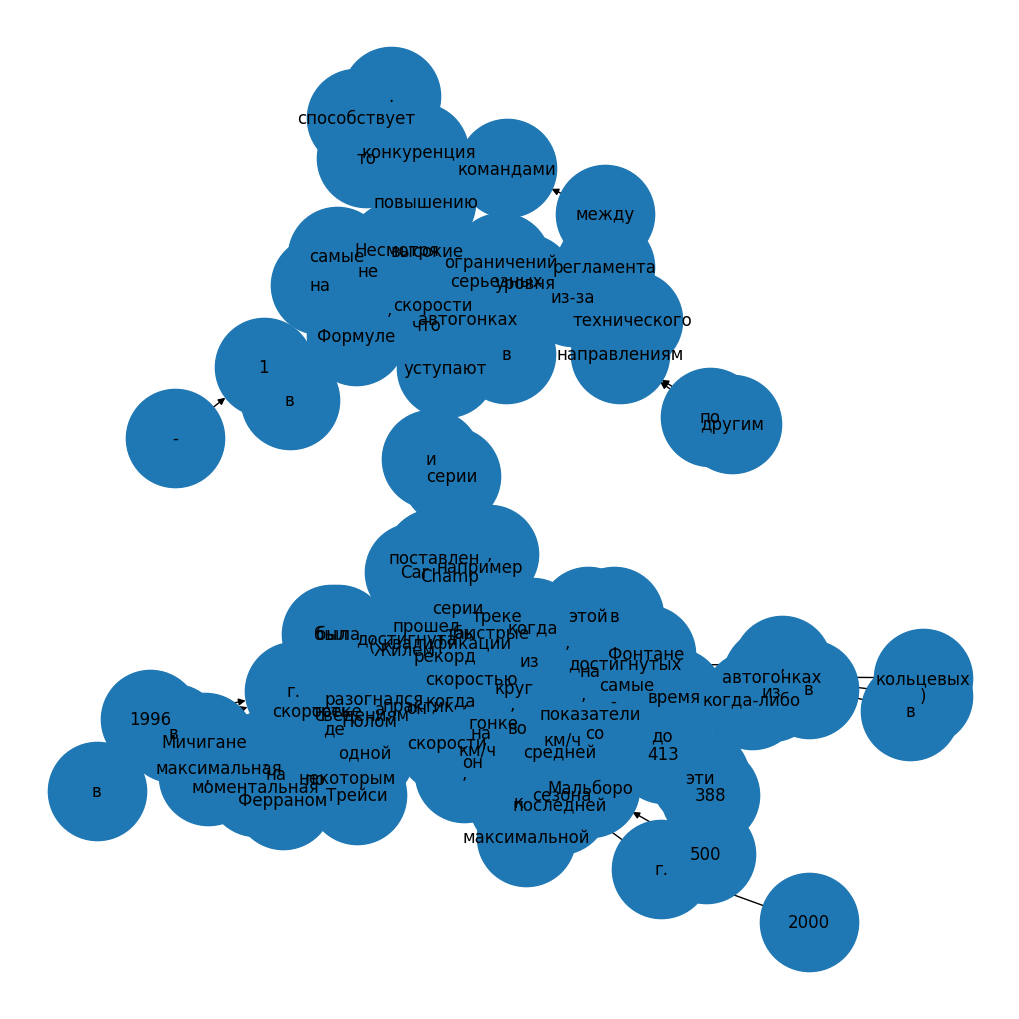

In [227]:
plt.figure(figsize=(10,10))
nx.draw(longest_sentence.nx_graph(), labels=longest_sentence.nx_labels, node_size=5000)

In [228]:
longest_sentence.nx_labels

{1: 'Несмотря',
 2: 'на',
 3: 'то',
 4: ',',
 5: 'что',
 6: 'из-за',
 7: 'серьезных',
 8: 'ограничений',
 9: 'регламента',
 10: 'скорости',
 11: 'в',
 12: 'Формуле',
 13: '-',
 14: '1',
 15: 'не',
 16: 'самые',
 17: 'высокие',
 18: 'в',
 19: 'автогонках',
 20: 'и',
 21: 'уступают',
 22: ',',
 23: 'например',
 24: ',',
 25: 'серии',
 26: 'Champ',
 27: 'Car',
 28: '(',
 29: 'так',
 30: ',',
 31: 'в',
 32: 'этой',
 33: 'серии',
 34: 'рекорд',
 35: 'максимальной',
 36: 'скорости',
 37: 'был',
 38: 'поставлен',
 39: 'Жилем',
 40: 'де',
 41: 'Ферраном',
 42: 'на',
 43: 'квалификации',
 44: 'к',
 45: 'последней',
 46: 'гонке',
 47: 'сезона',
 48: '2000',
 49: 'г.',
 50: 'Мальборо',
 51: '500',
 52: 'на',
 53: 'треке',
 54: 'в',
 55: 'Фонтане',
 56: ',',
 57: 'когда',
 58: 'он',
 59: 'прошел',
 60: 'круг',
 61: 'со',
 62: 'средней',
 63: 'скоростью',
 64: '388',
 65: 'км/ч',
 66: ',',
 67: 'а',
 68: 'максимальная',
 69: 'моментальная',
 70: 'скорость',
 71: ',',
 72: 'по',
 73: 'некоторым',
 7